In [1]:

! cd ../data/; FILELIST=" 200509 200508 200507 200506 200505 200504 200503 200502 200501 200430 200429 200428 200427 200426 200425 200424 200423 200422 200510 200511 200512 200513 200514 200515 200516 200517 200518 200519 200520 200521 200522 200523 200524 200525 200526 200527 200528 200529 200530 200531" ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ; echo $FILE:::::  ;  [ ! -f ../data/${FILE} ] && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE ; ls -altr $FILE ; done 

! ls -altr ../data/*cam*
! pwd 

200509_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 560033 may  8 20:58 200509_cam_covid19.pdf
200508_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 557770 may  8 10:43 200508_cam_covid19.pdf
200507_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 559899 may  7 07:51 200507_cam_covid19.pdf
200506_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 557792 may  5 23:33 200506_cam_covid19.pdf
200505_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 556266 may  5 09:09 200505_cam_covid19.pdf
200504_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 557086 may  3 23:41 200504_cam_covid19.pdf
200503_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 557075 may  2 23:22 200503_cam_covid19.pdf
200502_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 557127 may  2 09:29 200502_cam_covid19.pdf
200501_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 556974 may  1 20:11 200501_cam_covid19.pdf
200430_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 554446 abr 30 08:36 200430_cam_covid19.pdf
200429_cam_covid19.pdf:::::
-rw-r--r-- 1 root root 557572 ab

In [2]:
from tabula import read_pdf
import os 
import pandas as pd
import glob 
import re 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.141-1.b16.el7_3.x86_64/jre"

# Auxiliary functions
from datetime import datetime, date, time, timedelta

""" Rellenar dias vacios con interpolacion"""
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
                        datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
                        datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
                        freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    return df

def fet_daily_date_new_format(fecha): 
    df_pdf =  read_pdf('../data/'+fecha+'_cam_covid19.pdf',area=(000, 600, 400, 800) , pages='1')
    df = df_pdf[0]
    df = df['Unnamed: 0'].astype(str).str.replace(r".", '').replace("(", ' ')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]


    df = pd.DataFrame(data=df)
    df    

    dict = {}
    dict['HOSPITALES'] = df[df['Unnamed: 0'].str.contains('Hospitales')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['DOMICILIOS'] = df[df['Unnamed: 0'].str.contains('Domicilios')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['CENTROS SOCIOSANITARIOS'] = df[df['Unnamed: 0'].str.contains('Centros')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['OTROS LUGARES'] = df[df['Unnamed: 0'].str.contains('otros')].iloc[0]['Unnamed: 0'].split(' ')[0]

    cadena_a_parsear = df[df['Unnamed: 0'].str.contains('otal')].iloc[0]['Unnamed: 0']

    dict['FALLECIDOS TOTALES'] = re.search(r'(\d+)', cadena_a_parsear)[0]

    df = pd.DataFrame.from_dict(dict, orient='index').T
    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df.set_index('Fecha', inplace=True, drop=True)
    return df


def get_daily_data(fecha):
    if fecha > '200512' : 
        return fet_daily_date_new_format(fecha)
    
    col2str = {'dtype': str}
    kwargs = {'output_format': 'dataframe',
              'pandas_options': col2str,
              'stream': True}
    df_pdf =  read_pdf('../data/'+fecha+'_cam_covid19.pdf',pages='1',multiple_tables = True,**kwargs)

    
    df = df_pdf[0]

    df = df[df['Unnamed: 0'].notna()]
    df = df[(df['Unnamed: 0']=='HOSPITALES') | (df['Unnamed: 0'] == 'DOMICILIOS') | (df['Unnamed: 0'] == 'CENTROS SOCIOSANITARIOS') | (df['Unnamed: 0'] == 'OTROS LUGARES') | (df['Unnamed: 0'] == 'FALLECIDOS TOTALES')]
    df = df[['Unnamed: 0','Unnamed: 2']]
    df['Unnamed: 2'] = df['Unnamed: 2'].astype(str).str.replace(r".", '')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]

    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df = df.rename_axis(None)

    df.set_index('Fecha', inplace=True, drop=True)
    df.index
    df.dropna()
    #df = df.T
    return df

def get_all_data( ): 
    #BLACKLIST = ["200429","200422"]
    #BLACKLIST = ["200514",]
    BLACKLIST = []
    df = pd.DataFrame()
    list_df = []
 
    pdf_list= sorted(glob.glob('../data/*_cam_covid19.pdf'), 
                     key=os.path.getmtime,
                     reverse=True )
    
    for pdf_file in pdf_list:
        # extract fecha from username , eg : ../data/2200422_cam_covid19.pdf
        fecha = pdf_file.split('/')[2].split('_')[0]
        if fecha not in BLACKLIST:
            print("processing", fecha)
            df = get_daily_data(fecha) 
        list_df.append(df)

    df = pd.concat(list_df)
    df = df.astype(int)
    df = df.drop_duplicates()

    df = df.sort_values(by=['Fecha'], ascending=True)
    ###jaime
    #df = interpolate_dataframe(df,'D')
    #df.index.name = 'Fecha'

    df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
    df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
    df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)

    df = df.sort_values(by=['Fecha'], ascending=False)

    return df 

In [3]:
total =  get_all_data()

total

processing 200531
processing 200530
processing 200529
processing 200528
processing 200527
processing 200526
processing 200525
processing 200524
processing 200523
processing 200522
processing 200521
processing 200520
processing 200519
processing 200518
processing 200517
processing 200516
processing 200515
processing 200514
processing 200513
processing 200512
processing 200511
processing 200510
processing 200509
processing 200508
processing 200507
processing 200506
processing 200505
processing 200504
processing 200503
processing 200502
processing 200501
processing 200430
processing 200429
processing 200428
processing 200427
processing 200426
processing 200424
processing 200425
processing 200423
processing 200422


Got stderr: jun 01, 2020 8:26:01 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
jun 01, 2020 8:26:01 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored
jun 01, 2020 8:26:01 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
jun 01, 2020 8:26:01 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
jun 01, 2020 8:26:01 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored
jun 01, 2020 8:26:01 AM org.apache.pdfbox.pdmodel.fon

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,
2020-05-31,9074,878,4739,27,14718,30.0,15.0,47.0
2020-05-28,9044,876,4724,27,14671,56.0,28.0,90.0
2020-05-26,8988,870,4696,27,14581,81.0,73.0,164.0
2020-05-24,8907,860,4623,27,14417,87.0,69.0,171.0
2020-05-21,8820,848,4554,24,14246,72.0,29.0,102.0
2020-05-19,8748,847,4525,24,14144,108.0,15.0,126.0
2020-05-17,8640,844,4510,24,14018,67.0,19.0,87.0
2020-05-14,8573,843,4491,24,13931,52.0,19.0,74.0
2020-05-12,8521,840,4472,24,13857,117.0,34.0,153.0


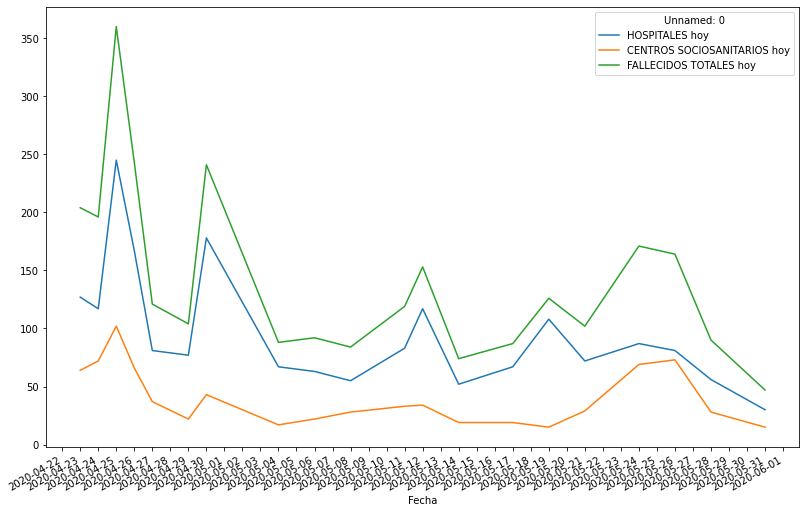

In [4]:
import pandas as pd
import io
import matplotlib.dates as mdates
from matplotlib import pyplot as plt



chart_df=total[['HOSPITALES hoy','CENTROS SOCIOSANITARIOS hoy','FALLECIDOS TOTALES hoy']]
chart_df.plot(legend=True,figsize=(13.5,9))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.show()



In [5]:
from IPython.display import display, HTML
HTML("<h2>Muertes medias diarias desde que la comunidad de Madrid publica datos</h2>")


In [6]:
# Calculamos los incrementos medios, desde que tenemos fechas
df = total

medias_datos = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) / df.shape[0] ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
medias_datos

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,91.904762,5.571429,38.428571,0.571429,136.47619


In [7]:
from IPython.display import display, HTML
HTML("<h2>Muertes medias diarias, últimos 7 días, con datos</h2>")


In [8]:
from datetime import date
df = total


inicio_crisis = df.head(7).index[6]
df=df.head(7)
dia_mas_reciente = df.index[0]
dias_transcurridos_inicio_crisis = dia_mas_reciente - inicio_crisis

medias_datos = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) /  dias_transcurridos_inicio_crisis.days  ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]

medias_datos
                                    

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,31.0,2.428571,16.357143,0.214286,50.0


In [9]:
from datetime import date
df = total


inicio_crisis = df.tail(7).index[0]
df=df.head(7)
dia_mas_reciente = df.index[0]
dias_transcurridos_inicio_crisis = dia_mas_reciente - inicio_crisis

medias_inicio_crisis = pd.DataFrame((df.head(1).max(axis=0)) / dias_transcurridos_inicio_crisis.days ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
medias_inicio_crisis
                       
                                    

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,283.5625,27.4375,148.09375,0.84375,459.9375


In [10]:
df = total


inicio_crisis = df.head(7).index[6]
inicio_crisis

Timestamp('2020-05-17 00:00:00')